In [1]:
import cv2
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from os.path import join
from helper_functions.displayFunctions import *

In [2]:
with open('predictions/saved_predictions.pkl', 'rb') as f:
    results = pickle.load(f)

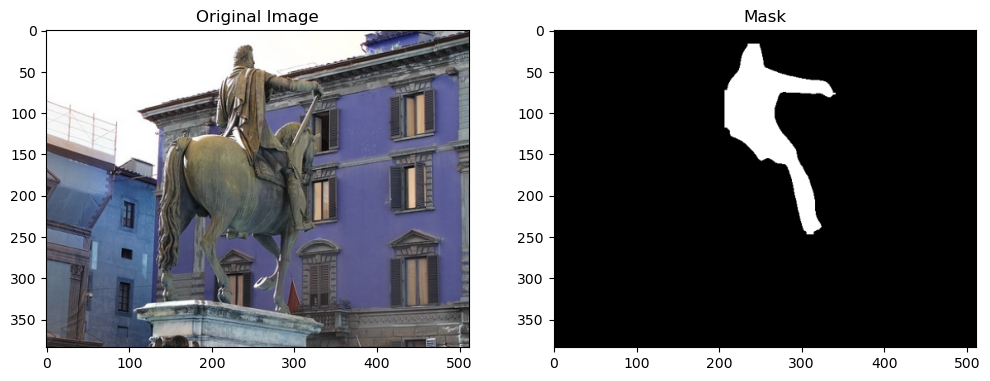

In [3]:
orig_img = cv2.imread('images/images_nat/FLICKR-AES -farm6_5482_11387807106_4f7c555026.jpg')

orig_shape = results['FLICKR-AES -farm6_5482_11387807106_4f7c555026.jpg'].masks[1].orig_shape
mask = results['FLICKR-AES -farm6_5482_11387807106_4f7c555026.jpg'].masks[1].data.cpu().numpy()[0]
mask = cv2.resize(mask, (orig_img.shape[1], orig_img.shape[0]))


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(orig_img)
ax[0].set_title('Original Image')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')
plt.show()


In [4]:
def getObjectBBoxes(results: dict, img_name: str):
    list_of_objects = []

    for i in range(len(results[img_name].boxes)):
        dictionary = {}

        orig_shape = results[img_name].masks[i].orig_shape
        new_shape = results[img_name].masks[i].data.cpu().numpy()[0].shape
        mask = results[img_name].masks[i].data.cpu().numpy()[0]
        mask = cv2.resize(mask, (orig_shape[1], orig_shape[0]))

        # x = results[img_name].boxes[i].xywh.cpu().numpy()[0][0] * (new_shape[1] / orig_shape[1])
        # y = results[img_name].boxes[i].xywh.cpu().numpy()[0][1] * (new_shape[0] / orig_shape[0])
        # w = results[img_name].boxes[i].xywh.cpu().numpy()[0][2] * (new_shape[1] / orig_shape[1])
        # h = results[img_name].boxes[i].xywh.cpu().numpy()[0][3] * (new_shape[0] / orig_shape[0])

        print(results[img_name].boxes[i].xyxy.cpu())
        x = results[img_name].boxes[i].xyxy.cpu().numpy()[0][0]
        y = results[img_name].boxes[i].xyxy.cpu().numpy()[0][1]
        x2 = results[img_name].boxes[i].xyxy.cpu().numpy()[0][2]
        y2 = results[img_name].boxes[i].xyxy.cpu().numpy()[0][3]
        w = x2 - x
        h = y2 - y

        print(x, y, w, h)
        cx = x + w/2
        cy = y + h/2
        print(cx, cy, w, h)

        # x = results[img_name].boxes[i].xywh.cpu().numpy()[0][0] * (orig_shape[1] / new_shape[1])
        # y = results[img_name].boxes[i].xywh.cpu().numpy()[0][1] * (orig_shape[0] / new_shape[0])
        # w = results[img_name].boxes[i].xywh.cpu().numpy()[0][2] * (orig_shape[1] / new_shape[1])
        # h = results[img_name].boxes[i].xywh.cpu().numpy()[0][3] * (orig_shape[0] / new_shape[0])

        dictionary['class'] = results[img_name].boxes[i].cls.cpu().numpy()[0]
        dictionary['confidence'] = results[img_name].boxes[i].conf.cpu().numpy()[0]
        dictionary['centerX'] = x + w/2
        dictionary['centerY'] = y + h/2
        dictionary['width_box'] = w
        dictionary['height_box'] = h
        dictionary['mask'] = mask

        list_of_objects.append(dictionary)

    return list_of_objects


getObjectBBoxes(results, 'FLICKR-AES -farm6_5482_11387807106_4f7c555026.jpg')[1]

tensor([[134.1046, 113.4325, 332.1273, 344.5274]])
134.10464 113.43251 198.0227 231.09492
233.11599731445312 228.97997283935547 198.0227 231.09492
tensor([[204.8797,  19.1996, 337.2769, 244.1649]])
204.87975 19.19956 132.3972 224.96536
271.0783462524414 131.68224143981934 132.3972 224.96536


{'class': 0.0,
 'confidence': 0.72064596,
 'centerX': 271.0783462524414,
 'centerY': 131.68224143981934,
 'width_box': 132.3972,
 'height_box': 224.96536,
 'mask': array([[          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        ...,
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0]], dtype=float32)}

In [5]:
def predictionsAsDF(results: dict, save_path: str = 'data_out/predictions.csv'):
    file_names = []
    bbox_num = []
    centerX = []
    centerY = []
    width_box = []
    height_box = []
    classes = []
    confidences = []
    axis = []
    rotations = []

    for img_name in tqdm(results.keys()):
        objects = getObjectBBoxes(results, img_name)

        for i in range(len(objects)):
            file_names.append(img_name)
            bbox_num.append(i)
            centerX.append(objects[i]['centerX'])
            centerY.append(objects[i]['centerY'])
            width_box.append(objects[i]['width_box'])
            height_box.append(objects[i]['height_box'])
            classes.append(objects[i]['class'])
            confidences.append(objects[i]['confidence'])
            axis.append('vertical_axis')
            rotations.append(0)
    
    df = pd.DataFrame({
        'file_name': file_names,
        'BBox_#': bbox_num,
        'centerX': centerX,
        'centerY': centerY,
        'width_box': width_box,
        'height_box': height_box,
        'class': classes,
        'confidence': confidences,
        'axis': axis,
        'rotation': rotations
    })
    df.to_csv('predictions/predictions.csv', index=False)

    if save_path is not None:
        df.to_csv(save_path, index=False)

    return df

predictions_DF = predictionsAsDF(results)

 16%|█▌        | 31/200 [00:00<00:00, 292.65it/s]

tensor([[163.1662, 260.2263, 221.4502, 340.7711]])
163.16617 260.22632 58.284073 80.54474
192.3082046508789 300.4986877441406 58.284073 80.54474
tensor([[276.6974, 266.3421, 338.2403, 340.7061]])
276.69745 266.3421 61.542816 74.364044
307.46885681152344 303.5241241455078 61.542816 74.364044
tensor([[180.3499, 262.1356, 325.4096, 340.8515]])
180.34988 262.13556 145.05972 78.71597
252.87974548339844 301.49354553222656 145.05972 78.71597
tensor([[328.7542, 254.7082, 348.3323, 340.5634]])
328.7542 254.70818 19.578125 85.85527
338.54327392578125 297.6358108520508 19.578125 85.85527
tensor([[195.2644, 252.9880, 215.3965, 278.9168]])
195.2644 252.98799 20.13208 25.928848
205.3304443359375 265.9524154663086 20.13208 25.928848
tensor([[237.8634, 247.8230, 280.9012, 338.4423]])
237.8634 247.82303 43.03775 90.61923
259.3822784423828 293.1326446533203 43.03775 90.61923
tensor([[241.2128, 167.5607, 288.7204, 244.0461]])
241.2128 167.5607 47.50763 76.48535
264.96661376953125 205.80337524414062 47.50

 30%|███       | 61/200 [00:00<00:00, 177.67it/s]

386.71313 165.84338 28.708496 39.92964
401.0673828125 185.8082046508789 28.708496 39.92964
tensor([[159.3344, 154.7874, 179.2246, 188.7343]])
159.3344 154.78741 19.890244 33.946854
169.2795181274414 171.7608413696289 19.890244 33.946854
tensor([[179.8434, 160.4816, 210.6094, 190.9151]])
179.84341 160.48155 30.766006 30.433533
195.2264175415039 175.6983184814453 30.766006 30.433533
tensor([[ 87.7626, 152.5437, 104.5257, 185.2488]])
87.76257 152.54373 16.763123 32.705032
96.14413452148438 168.89624786376953 16.763123 32.705032
tensor([[424.4971, 166.9672, 467.0182, 197.6627]])
424.49707 166.96721 42.521088 30.695465
445.7576141357422 182.31494140625 42.521088 30.695465
tensor([[133.8109, 148.4686, 152.3704, 186.2971]])
133.81094 148.46861 18.559418 37.828506
143.0906524658203 167.38286590576172 18.559418 37.828506
tensor([[209.7038, 166.2258, 225.8872, 188.9985]])
209.70378 166.22585 16.18341 22.772629
217.7954864501953 177.6121597290039 16.18341 22.772629
tensor([[147.5316, 149.8980, 16

 72%|███████▎  | 145/200 [00:00<00:00, 314.65it/s]

tensor([[ 41.0630,  96.9984, 327.2841, 403.7408]])
41.06299 96.99839 286.22116 306.74243
184.17356872558594 250.3696060180664 286.22116 306.74243
tensor([[266.8469,  53.8499, 381.4129, 155.8338]])
266.8469 53.84989 114.56604 101.983864
324.1299133300781 104.84182357788086 114.56604 101.983864
tensor([[ 52.4584, 247.3520, 100.5418, 291.9376]])
52.458435 247.352 48.08335 44.585556
76.5001106262207 269.64478302001953 48.08335 44.585556
tensor([[3.1416e-01, 2.8070e+02, 4.9223e+01, 3.3080e+02]])
0.31416017 280.70078 48.908485 50.10031
24.768402874469757 305.7509307861328 48.908485 50.10031
tensor([[ 33.9793, 272.3196,  81.2274, 321.3694]])
33.97931 272.31964 47.248047 49.049744
57.60333251953125 296.8445129394531 47.248047 49.049744
tensor([[260.7517, 233.4744, 294.2531, 256.3353]])
260.75168 233.4744 33.501465 22.860931
277.5024108886719 244.9048614501953 33.501465 22.860931
tensor([[7.3523e-02, 3.0151e+02, 3.4333e+01, 3.3743e+02]])
0.07352295 301.5113 34.259953 35.9162
17.20349922031164 3

100%|██████████| 200/200 [00:00<00:00, 253.39it/s]

tensor([[ 38.6369, 178.5319, 502.4378, 272.5948]])
38.636868 178.53189 463.80096 94.0629
270.53734970092773 225.56333923339844 463.80096 94.0629
tensor([[225.0626, 217.9184, 252.7768, 250.6260]])
225.0626 217.91837 27.714157 32.70761
238.91968536376953 234.2721710205078 27.714157 32.70761
tensor([[224.7788, 189.1973, 324.5316, 278.7296]])
224.77884 189.19725 99.75278 89.53233
274.6552276611328 233.96341705322266 99.75278 89.53233
tensor([[ 35.0568,  73.6709, 201.0728, 224.1224]])
35.05677 73.67089 166.01602 150.45148
118.06478118896484 148.8966293334961 166.01602 150.45148
tensor([[328.1721,  41.7203, 489.6833, 185.8172]])
328.17212 41.720264 161.51114 144.09698
408.9276885986328 113.76875686645508 161.51114 144.09698
tensor([[199.2502,  92.7649, 316.4065, 208.9033]])
199.25018 92.76487 117.15628 116.138405
257.8283233642578 150.8340721130371 117.15628 116.138405
tensor([[  1.4920,   0.9024, 509.8940, 492.4842]])
1.4919922 0.90244144 508.40195 491.58176
255.6929657459259 246.6933197379

In [6]:
predictions_DF[predictions_DF['file_name'] == 'FLICKR-AES -farm6_5482_11387807106_4f7c555026.jpg']

,file_name,BBox_#,centerX,centerY,width_box,height_box,class,confidence,axis,rotation
361,FLICKR-AES -farm6_5482_11387807106_4f7c555026.jpg,0,233.115997,228.979973,198.022705,231.094925,17.0,0.919790,vertical_axis,0
362,FLICKR-AES -farm6_5482_11387807106_4f7c555026.jpg,1,271.078346,131.682241,132.397202,224.965363,0.0,0.720646,vertical_axis,0


file_name     FLICKR-AES -farm6_5482_11387807106_4f7c555026.jpg
BBox_#                                                        1
centerX                                              271.078346
centerY                                              131.682241
width_box                                            132.397202
height_box                                           224.965363
class                                                       0.0
confidence                                             0.720646
axis                                              vertical_axis
rotation                                                      0
Name: 362, dtype: object


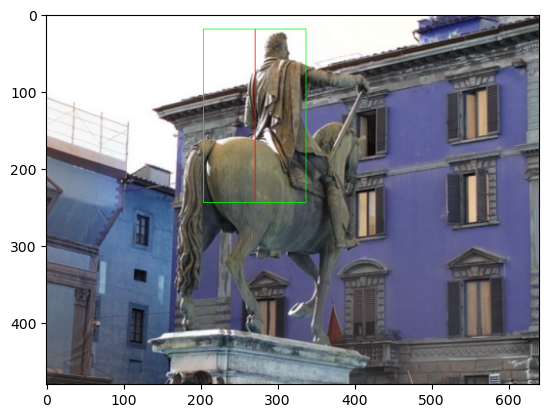

In [7]:
i = 362

print(predictions_DF.iloc[i])

img = cv2.imread(join('images', 'images_nat', predictions_DF.iloc[i]['file_name']))

img = cv2.resize(img, (640, 480))

drawBB(img, predictions_DF.iloc[i])

plt.imshow(img)
plt.show()